In [ ]:
from app.services.hantu_services.auth_service import AuthService


auth_service = AuthService()
# access token 발급
access_token = auth_service.get_access_token()

In [5]:
from app.services.hantu_services.quotations_service import QuotationsService


quotations_service = QuotationsService(access_token)

In [ ]:
# 주식현재가 시세
inquire_price_res = quotations_service.inquire_price("005930")

In [ ]:
print(
    inquire_price_res["stck_prpr"],  # 주식 현재가
    inquire_price_res["prdy_vrss"],  # 전일대비
    inquire_price_res["prdy_ctrt"],  # 전일대비율
    inquire_price_res[
        "prdy_vrss_sign"
    ],  # 전일 대비 부호 1: 상한, 2: 상승, 3: 보합, 4: 하한, 5: 하락
    inquire_price_res["stck_oprc"],  # 주식 시가
    inquire_price_res["stck_hgpr"],  # 주식 최고가
    inquire_price_res["stck_lwpr"],  # 주식 최저가
    inquire_price_res["stck_mxpr"],  # 주식 상한가
    inquire_price_res["stck_llam"],  # 주식 하한가
    inquire_price_res["stck_sdpr"],  # 주식 기준가
    inquire_price_res[
        "mrkt_warn_cls_code"
    ],  # 시장경고코드 00: 없음, 01: 투자주의, 02: 투자경고, 03: 투자위험
)

In [8]:
from app.services.hantu_services.trading_service import TradingService


trading_service = TradingService(access_token)

In [9]:
# 주식주문(현금)
order_cash_res = trading_service.order_cash("005930", "1", "40000")

In [ ]:
# 주식일별주문체결조회
inquire_daily_ccld_res = trading_service.inquire_daily_ccld()
print(inquire_daily_ccld_res)
# inquire_daily_ccld_res[0]["odno"]  # 주문번호

In [ ]:
def filter_ticker(obj):
    return True if obj["pdno"] == "005930" else False


filtered_list = list(filter(filter_ticker, inquire_daily_ccld_res))

if len(filtered_list) > 0:
    # 주식주문(정정취소)
    order_rvsenclcl_res = trading_service.order_rvsecncl(filtered_list[0]["odno"])
    print(order_rvsenclcl_res["msg_cd"], order_rvsenclcl_res["msg1"])
else:
    print("주문번호가 존재하지 않습니다.")

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine("sqlite:///./app/connection/test.db", echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionLocal()

In [6]:
import pandas as pd
from sqlalchemy import func
from app.entities.kor_ticker_entity import KorTickerEntity


max_subquery = session.query(func.max(KorTickerEntity.baseDt))
query_set = session.query(KorTickerEntity).filter(
    KorTickerEntity.baseDt == max_subquery.scalar_subquery(),
    KorTickerEntity.itemCtg == "보통주",
)
df = pd.read_sql(query_set.statement, query_set.session.bind)

In [3]:
# 시총 작은 순위로 20개 정렬
df_rank = df["mrktTotAmt"].rank(axis=0, ascending=True)
result = df[df_rank < 20].sort_values(by=["mrktTotAmt"], ascending=True)

In [2]:
import pandas as pd

from app.services.kor_price_service import KorPriceService


kor_price_service = KorPriceService(session)
price_df = kor_price_service.get_year_price(is_df=True)
price_df["baseDt"] = pd.to_datetime(price_df["baseDt"])  # 날짜형식으로 변환
price_df = price_df.sort_values(by=["itemCd", "baseDt"], ascending=True).reset_index(drop=True)

In [3]:
import pandas_ta as ta
import pandas as pd


# 각 종목별로 다양한 기간의 SMA 계산
def calculate_sma(group, lengths):
    for length in lengths:
        group[f"SMA_{length}"] = ta.sma(group["closePrice"], length=length)
    return group.dropna(how="all", axis=1)

price_df["ticker"] = price_df["itemCd"]
# 원하는 SMA 기간들
sma_lengths = [10, 20, 50, 120]
# 그룹화하여 SMA 계산 적용
price_df_sma = (
    price_df.groupby("itemCd")
    .apply(lambda x: calculate_sma(x,sma_lengths), include_groups=False)
    .reset_index(drop=True)
)

# price_merge = price_df_sma.merge(price_df["itemCd"], left_index=True, right_index=True)

In [4]:
one_price = price_df_sma[price_df_sma["ticker"]== "000020"]
one_price = one_price.iloc[119:]

Text(0.5, 0, 'Month')

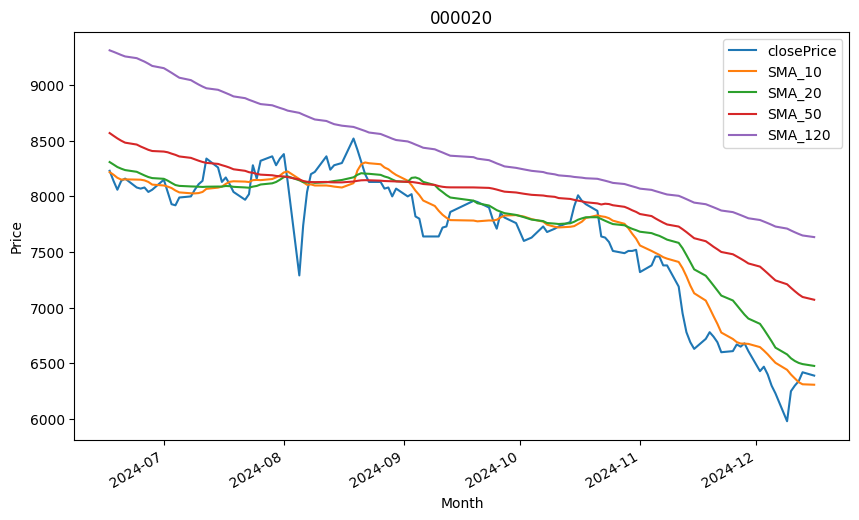

In [5]:
ax1 = one_price.plot(figsize=(10,6),x="baseDt", y="closePrice", title="000020")
ax2 = one_price.plot(figsize=(10,6),x="baseDt", y="SMA_10", ax=ax1, )
ax3 = one_price.plot(figsize=(10,6),x="baseDt", y="SMA_20", ax=ax1, )
ax4 = one_price.plot(figsize=(10,6),x="baseDt", y="SMA_50", ax=ax1, )
ax5 = one_price.plot(figsize=(10,6),x="baseDt", y="SMA_120", ax=ax1, )

ax1.set_ylabel("Price")
ax1.set_xlabel("Month")

In [6]:
price_df_sma["ticker_1"] = price_df_sma["ticker"]
def removeNa(group):
    return group.iloc[119:]

price_merge_remove = price_df_sma.groupby(by="ticker").apply(removeNa, include_groups=False).reset_index(drop=True)

In [8]:
price_merge_remove["ticker_2"] = price_merge_remove["ticker_1"]
def filter_last(group):
    return group.iloc[-1:]

filtered_last_data = price_merge_remove.groupby(by="ticker_1").apply(filter_last, include_groups=False).reset_index(drop=True)